## Imports and definitions

In [1]:
# Whether to export the plots to .pdf or to .png, or only show them in the notebook.
EXPORT_PLOTS_TO_LATEX = True
EXPORT_PLOTS_TO_PNG = False

# Page width in inches (!?) of our specific LaTex layout, so the text in the
# exported PDFs comes out scaled properly.
PAGE_WIDTH = 5.87614

import matplotlib.pyplot as plt
import matplotlib
from matplotlib.lines import Line2D
import seaborn as sns
import numpy as np
import pandas as pd
import word_peaks
from tqdm import tqdm
from pathlib import Path

if EXPORT_PLOTS_TO_LATEX:
	matplotlib.rcParams.update({
		"pgf.texsystem": "pdflatex",
		"font.family": "serif",
		"font.size": 16,
		"text.usetex": True,
		"pgf.rcfonts": False,
	})
else:
	matplotlib.rcParams.update({
		"pgf.texsystem": "xelatex",
		"font.family": "serif",
		"text.usetex": False,
		"pgf.rcfonts": True,
	})

In [14]:
def save_and_show(name):
	if EXPORT_PLOTS_TO_LATEX:
		plt.savefig(f"plots/{name}.pdf", bbox_inches="tight")
	elif EXPORT_PLOTS_TO_PNG:
		plt.savefig(f"plots/{name}.png", bbox_inches="tight")
	else:
		plt.show()

def algo_colour(memetic = False, elitist = False, bs = False) -> str:
	if memetic and elitist:
		return "orange"
	elif memetic:
		return "steelblue"
	elif elitist:
		return "mediumseagreen"
	elif bs:
		return "black"
	else:
		return "dimgrey"

def algo_linestyle(algo: str) -> str:
	if "tour" in algo.lower():
		return "dotted"
	elif algo.lower() == "binary search" or algo.lower() == "bs":
		return "dashed"
	else:
		return "solid"

line_legend = [
	Line2D([0], [0], color=algo_colour(bs=True), lw=2, linestyle=algo_linestyle("Binary Search"), label='Binary Search'),
	Line2D([0], [0], color='black', lw=2, linestyle='-', label='Probabilistic selection'),
	Line2D([0], [0], color='black', lw=2, linestyle='dotted', label='Tournament selection'),
	Line2D([0], [0], color=algo_colour(), lw=2, linestyle='-', label='Plain GA'),
	Line2D([0], [0], color=algo_colour(memetic=True), lw=2, linestyle='-', label='Memetic'),
	Line2D([0], [0], color=algo_colour(elitist=True), lw=2, linestyle='-', label='Elitist'),
	Line2D([0], [0], color=algo_colour(memetic=True, elitist=True), lw=2, linestyle='-', label='Memetic and Elitist')
]

In [3]:
n_iterations = 400
max_guesses = 50
measure_diversity = True

## Comparison Between Algorithms

### Run GAs

In [22]:
memetic_vals =      [False] +       [False, True, False, True]*2
elitist_vals =      [False] +       [False, False, True, True]*2
use_bs_vals =       [True] +        [False, False, False, False]*2
parent_selection_vals = [None] + [word_peaks.GA.probabilistic_selection]*4 + [word_peaks.GA.tournament_selection]*4
label_vals = ["BS", "Prob", "Prob M", "Prob E", "Prob M+E", "Tour", "Tour M", "Tour E", "Tour M+E"]
all_guesses = np.zeros((len(elitist_vals), n_iterations))
all_diversities = np.full((len(elitist_vals), n_iterations, max_guesses), np.NaN)

for param_i, (memetic, elitist, use_bs, parent_selection_func, label) in enumerate(zip(memetic_vals, elitist_vals, use_bs_vals, parent_selection_vals, label_vals)):
    print(f"Running {label}...")
    for run_i in tqdm(range(n_iterations)):
        guesses, diversities = word_peaks.play_game(parent_selection_function=parent_selection_func, elitist=elitist, memetic=memetic, k=5, mu=0.15, use_bs=use_bs, measure_diversity=measure_diversity, max_guesses=max_guesses, targets_path = Path("dictionaries/word_peaks_targets.txt"))
        all_guesses[param_i, run_i] = guesses
        if measure_diversity: all_diversities[param_i, run_i,:] = diversities

Running Binary Search...


100%|██████████| 400/400 [00:01<00:00, 327.12it/s]


Running Prob...


100%|██████████| 400/400 [02:06<00:00,  3.17it/s]


Running Prob (M)...


100%|██████████| 400/400 [02:06<00:00,  3.15it/s]


Running Prob(E)...


100%|██████████| 400/400 [02:15<00:00,  2.96it/s]


Running Prob(M, E)...


100%|██████████| 400/400 [02:12<00:00,  3.02it/s]


Running Tour...


100%|██████████| 400/400 [00:58<00:00,  6.89it/s]


Running Tour (M)...


100%|██████████| 400/400 [01:12<00:00,  5.49it/s]


Running Tour (E)...


100%|██████████| 400/400 [01:01<00:00,  6.48it/s]


Running Tour (M, E)...


100%|██████████| 400/400 [01:07<00:00,  5.91it/s]


### Save & Load Results

In [ ]:
# Save results
with open('./results/label_vals.npy', 'wb') as f:
    np.save(f, np.array(label_vals))
with open('./results/all_guesses.npy', 'wb') as f:
    np.save(f, all_guesses)
if measure_diversity:
    with open('./results/all_diversities.npy', 'wb') as f:
        np.save(f, all_diversities)

In [4]:
with open('./results/label_vals.npy', 'rb') as f:
    label_vals = np.load(f)
with open('./results/all_guesses.npy', 'rb') as f:
    all_guesses = np.load(f)
if measure_diversity:
    with open('./results/all_diversities.npy', 'rb') as f:
        all_diversities = np.load(f)

In [5]:
data = pd.DataFrame([
	{"algorithm": l, "guesses": g}
	for (i, l) in enumerate(label_vals)
	for g in all_guesses[i]
])
data

algorithm  guesses
0           BS      3.0
1           BS      4.0
2           BS      3.0
3           BS      4.0
4           BS      3.0
...        ...      ...
3595  Tour M+E      4.0
3596  Tour M+E      6.0
3597  Tour M+E      3.0
3598  Tour M+E     11.0
3599  Tour M+E      6.0

[3600 rows x 2 columns]

### Plots and Analyses

In [62]:
for param_i, label in enumerate(label_vals):
    n_successes = sum(all_guesses[param_i] <= 6)
    print(f"{label}:\t{n_successes / n_iterations * 100:.0f}%")

BS:	98%
Prob:	88%
Prob M:	88%
Prob E:	87%
Prob M+E:	88%
Tour:	88%
Tour M:	90%
Tour E:	83%
Tour M+E:	89%


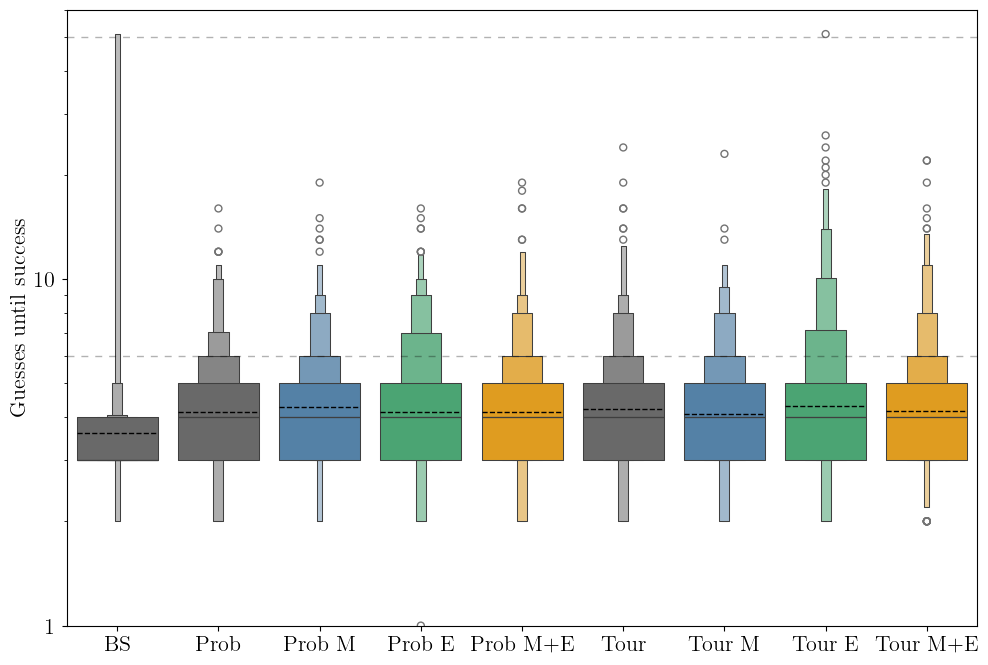

In [63]:
plt.figure(figsize=(2*PAGE_WIDTH, 8))
plt.axhline(6, dashes=[5,5], linewidth=1, c="k", alpha=0.3)
plt.axhline(max_guesses, dashes=[5,5], linewidth=1, c="k", alpha=0.3)
sns.boxenplot(data, x="algorithm", y="guesses", hue="algorithm", log_scale=True, palette=[algo_colour(),
	algo_colour(), algo_colour(memetic=True), algo_colour(elitist=True), algo_colour(memetic=True, elitist=True),
	algo_colour(), algo_colour(memetic=True), algo_colour(elitist=True), algo_colour(memetic=True, elitist=True)])

# Draw mean lines: https://stackoverflow.com/a/67579487
sns.boxplot(data,
	x="algorithm",
	y="guesses",
	showmeans=True,
	meanline=True,
	meanprops={'color': 'k', 'ls': '--', 'lw': 1},
	medianprops={'visible': False},
	whiskerprops={'visible': False},
	zorder=10,
	showfliers=False,
	showbox=False,
	showcaps=False)

plt.xlabel(None)
plt.ylabel("Guesses until success")
plt.gca().yaxis.set_major_formatter("{x:g}")
plt.ylim((1,max_guesses+10))
save_and_show("evaluations-to-solution")

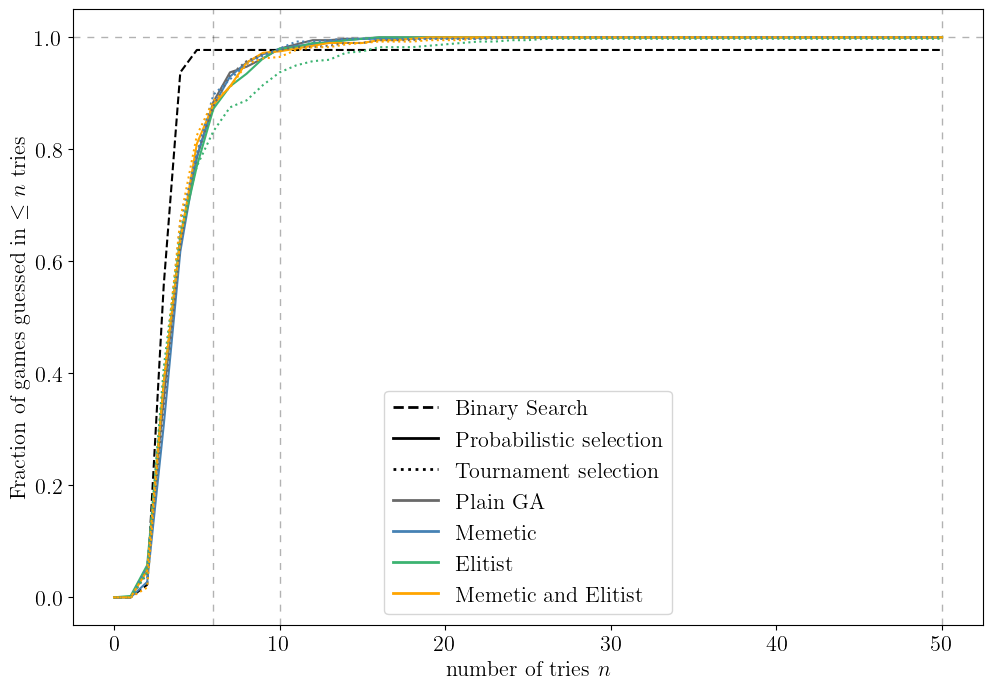

In [21]:
# Games guessed in <=n tries
successes = [[sum(guesses <= n) / n_iterations for n in range(max_guesses+1)] for guesses in all_guesses]

plt.figure(figsize=(2*PAGE_WIDTH, 8))
plt.axhline(1, dashes=[5,5], linewidth=1, c="k", alpha=0.3)
plt.axvline(max_guesses, dashes=[5,5], linewidth=1, c="k", alpha=0.3)
plt.axvline(6, dashes=[5,5], linewidth=1, c="k", alpha=0.3)
plt.axvline(10, dashes=[5,5], linewidth=1, c="k", alpha=0.3)
for (i, label) in enumerate(label_vals):
	plt.plot(successes[i], label=label, linestyle=algo_linestyle(label), color=algo_colour(memetic="M" in label, elitist="E" in label, bs=label == "BS"))
plt.xlabel("number of tries $n$")
plt.ylabel("Fraction of games guessed in $\leq n$ tries")
# plt.gca().set_xscale("log")
# plt.gca().xaxis.set_major_formatter("{x:g}")
plt.legend(handles=line_legend)
save_and_show("success-rate")

C:\Users\dante\AppData\Local\Temp\ipykernel_13492\573483250.py:1: RuntimeWarning: Mean of empty slice
  div_avg_per_gen = np.nanmean(all_diversities, axis=1)


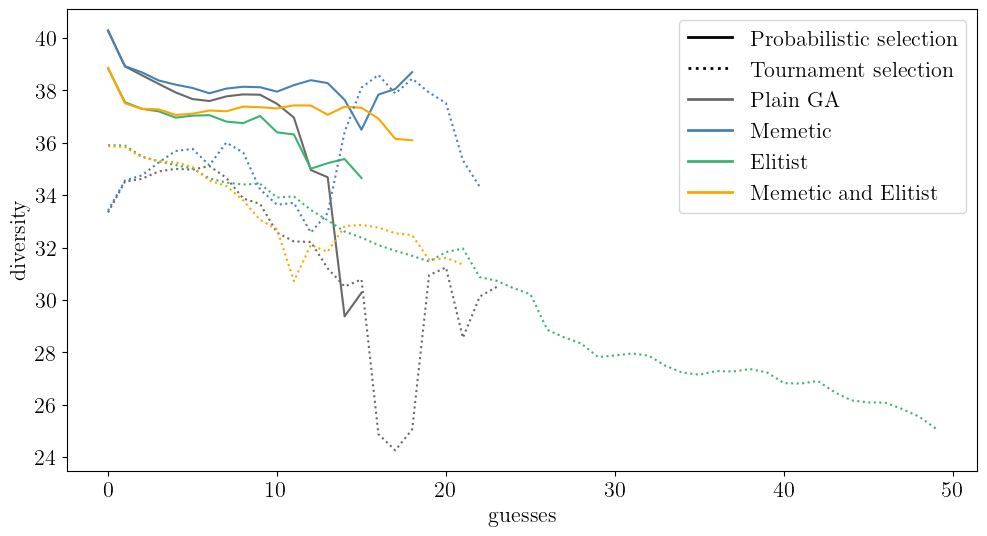

In [64]:
div_avg_per_gen = np.nanmean(all_diversities, axis=1)
plt.figure(figsize=(2*PAGE_WIDTH, 6))
for i, label in enumerate(label_vals):
    if i == 0: continue # skip binary search
    plt.plot(div_avg_per_gen[i,:], label=label, linestyle=algo_linestyle(label), color=algo_colour("M" in label, "E" in label))
plt.legend(handles=line_legend[1:], loc='upper right')
plt.xlabel("guesses")
plt.ylabel("diversity")
save_and_show("diversity")

## Intermezzo: Fitness Landscape

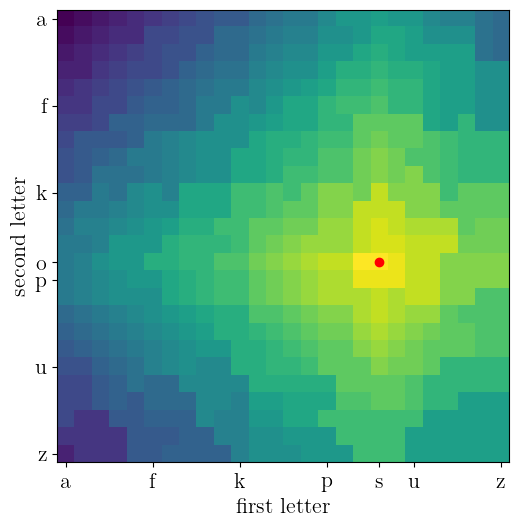

In [755]:
# got dict-2.txt via:
# python .\make_word_list.py -i .\dictionaries\count_1w.txt --sample first -n 300 -o .\dictionaries\dict-2.txt 2

use_optimal_fitness = True
do_clamp = True

wp = word_peaks.WordPeaks(inf_guesses=True, targets_path=Path("dictionaries/dict-2.txt"))
# ga = word_peaks.GA(wp, word_peaks.GA.tournament_selection, do_print=False)
ga = word_peaks.BinarySearcher(wp, do_print=False)
wp.target = "so"

words = np.array([
	[
		wp.make_valid_word(chr(a) + chr(b)) if do_clamp else chr(a) + chr(b)
		for a in range(ord("a"), ord("z")+1)
	]
	for b in range(ord("a"), ord("z")+1)
])

fitness = np.vectorize((lambda x: word_peaks.GA.debug_optimal_fitness(ga, x)) if use_optimal_fitness else lambda x: word_peaks.GA.fitness(ga, x))
fitnesses = []
fitnesses.append(fitness(words))
i = 0
while ga.iteration() != word_peaks.EQUAL_HINT_STR*wp.word_len and i < 10:
	fitnesses.append(fitness(words))
	i += 1

plt.figure(figsize=(PAGE_WIDTH, PAGE_WIDTH))
plt.imshow(fitnesses[-1])
plt.scatter(ord("s") - ord("a"), ord("o") - ord("a"), c="r")
plt.xlabel("first letter")
plt.gca().set_xticks(sorted([i for i in range(26) if i % 5 == 0 or ord('a') + i == ord('s')]))
plt.gca().xaxis.set_major_formatter(lambda x, _: chr(ord('a') + int(x)))
plt.ylabel("second letter")
plt.gca().set_yticks(sorted([i for i in range(26) if i % 5 == 0 or ord('a') + i == ord('o')]))
plt.gca().yaxis.set_major_formatter(lambda x, _: chr(ord('a') + int(x)))
save_and_show("fitness-landscape-" + ("optimal" if use_optimal_fitness else "normal"))

## Comparison Between Word Lengths

### Run GAs

In [722]:
word_lengths = [2, 3, 4, 5, 6, 7, 8, 9, 10]
use_bs_vals = [True, False]
word_lengths = np.zeros((len(word_lengths), len(use_bs_vals), n_iterations))

for param_i, word_length in enumerate(word_lengths):
    for param_j, use_bs in enumerate(use_bs_vals):
        algo = "Binary Search" if use_bs else "GA"
        print(f"Running {algo} {word_length}-letter...")
        targets_path = f"dictionaries/dict-{word_length}.txt"
        for run_i in tqdm(range(n_iterations)):
            guesses, diversities = word_peaks.play_game(parent_selection_function=word_peaks.GA.tournament_selection, elitist=False, memetic=True, k=5, mu=0.15, use_bs=use_bs, measure_diversity=False, max_guesses=max_guesses, targets_path=targets_path)
            word_lengths[param_i, param_j, run_i] = guesses

Running Binary Search 2-letter...


100%|██████████| 400/400 [00:00<00:00, 1032.33it/s]


Running GA 2-letter...


100%|██████████| 400/400 [00:30<00:00, 13.10it/s]


### Save & Load Results

In [733]:
# Save results
with open('./results/word_lengths.npy', 'wb') as f:
    np.save(f, word_lengths)

In [728]:
with open('./results/word_lengths.npy', 'rb') as f:
    word_lengths = np.load(f)

In [731]:
word_lengths_data = pd.DataFrame([
	{"word length": l, "algorithm": algo, "guesses": g}
	for (i, l) in enumerate(word_lengths)
	for (j, algo) in enumerate(["Binary Search", "GA"])
	for g in word_lengths[i,j]
])
word_lengths_data

word length      algorithm  guesses
0               2  Binary Search      6.0
1               2  Binary Search      5.0
2               2  Binary Search      5.0
3               2  Binary Search      5.0
4               2  Binary Search      2.0
...           ...            ...      ...
7195           10             GA      4.0
7196           10             GA      3.0
7197           10             GA      9.0
7198           10             GA      2.0
7199           10             GA      2.0

[7200 rows x 3 columns]

### Plots and Analyses

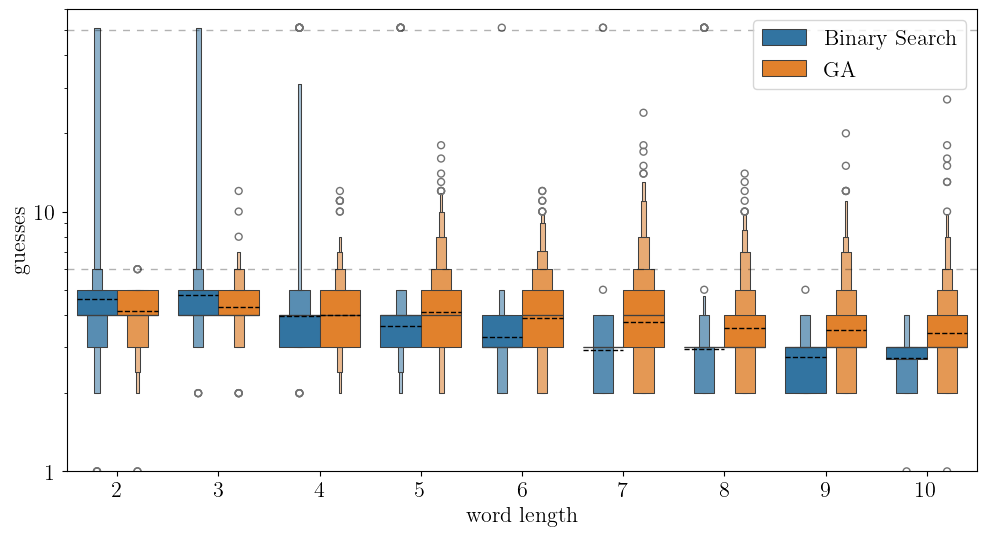

In [732]:
plt.figure(figsize=(2*PAGE_WIDTH, 6))
plt.axhline(6, dashes=[5,5], linewidth=1, c="k", alpha=0.3)
plt.axhline(max_guesses, dashes=[5,5], linewidth=1, c="k", alpha=0.3)
# sns.pointplot(word_lengths_data, x="word length", y="guesses", hue="algorithm", dodge=True, errorbar="pi", log_scale=True)
sns.boxenplot(word_lengths_data, x="word length", y="guesses", hue="algorithm", log_scale=True)
# Draw mean lines: https://stackoverflow.com/a/67579487
sns.boxplot(word_lengths_data,
	x="word length",
	y="guesses",
	hue="algorithm",
	showmeans=True,
	meanline=True,
	meanprops={'color': 'k', 'ls': '--', 'lw': 1},
	medianprops={'visible': False},
	whiskerprops={'visible': False},
	zorder=10,
	showfliers=False,
	showbox=False,
	showcaps=False,
	legend=False)
# sns.stripplot(word_lengths_data, x="word length", y="guesses", hue="algorithm", alpha=0.3, size=2, dodge=True, log_scale=True, jitter=0.3, legend=False)
# sns.pointplot(word_lengths_data, x="word length", y="guesses", hue="algorithm", alpha=0.8, dodge=0.4, linestyle="none", errorbar=None, marker="_", markersize=28, markeredgewidth=1)
plt.gca().yaxis.set_major_formatter("{x:g}")
plt.ylim((1,max_guesses+10))
plt.legend().set_title(None)
save_and_show("word-lengths")

## Unused Plots

In [ ]:
ylim = 100
bins = [x for x in range(max_guesses + 2)]
for param_i, label in enumerate(label_vals):
    plt.figure(figsize=(6, 4))
    plt.title(label)
    plt.xlabel("Guesses until success")
    plt.ylabel("Count")
    plt.ylim((0, ylim))
    plt.hist(all_guesses[param_i], bins=bins)
    plt.axvline(x = max_guesses, color = 'r', label = 'Last allowed attempt')
    plt.legend()
    save_and_show(f"guesses-{label}")

In [ ]:
# Average Evaluations to Solution
guesses = [np.mean(guesses) for guesses in all_guesses]
plt.figure(figsize=(10, 6))
plt.bar(label_vals, guesses)
plt.title("Average Evaluations to Solution (AES) by algorithm")
plt.ylabel("Mean number of guesses")
save_and_show("average-evaluations-to-solution")

plt.figure(figsize=(10, 6))
plt.boxplot([guesses for guesses in all_guesses], labels=label_vals)
plt.title("Evaluations to Solution by algorithm")
plt.ylabel("Number of guesses")
save_and_show("evaluations-to-solution")

In [ ]:
# Success Rate
successes = [sum(guesses <= 6) / n_iterations for guesses in all_guesses]
plt.figure(figsize=(10, 6))
plt.bar(label_vals, successes)
plt.title("Success rate (SR) by algorithm")
plt.ylabel("Fraction of games won (guessed within 6 tries)")
plt.ylim((0, 1))
save_and_show("success-rate")

In [ ]:
# Success Rate
fails = [sum(guesses >= max_guesses-1) / n_iterations for guesses in all_guesses]
plt.figure(figsize=(10, 6))
plt.bar(label_vals, fails)
plt.title("Failure rate by algorithm")
plt.ylabel("Fraction of words never guessed")
# plt.ylim((0, 1))
save_and_show("failure-rate")